# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

This notebook analysis neutralization of SARS-COV-2/Wu-1 virus by sera from vaccinated individuals on 293T cell clones that express different levels of ACE2.

### Set up Analysis

In [1]:
import os
import warnings

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data
We read in fraction infectivirty data for different cell lines and import sera information.

In [6]:
frac_infect = list() # create df list

for f in config['depletion_neuts'].keys():
    df = (pd.read_csv(f, index_col=0))
    frac_infect.append(df)  
frac_infect = pd.concat(frac_infect)

frac_infect['serum'] = frac_infect['serum'] + '__' + frac_infect['cells']

frac_infect['virus'] = frac_infect['virus'].str.replace('post-depletion','depleted')
frac_infect['virus'] = frac_infect['virus'].str.replace('pre-depletion','not depleted')


In [7]:
#read in sample info
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates())

sample_information['sorted']=sample_information['subject_name'].str[:-1].astype(int)
sample_information = sample_information.sort_values('sorted')

#store sera names in a list to later convert to factors for plotting
cat_order_sera = sample_information['serum'].tolist()


In [8]:
#read in ACE2 expression info
ACE2_expression_df = (pd.read_csv(config['ACE2_expression_df'])
                      .drop_duplicates())

## Fit Hill curve 

We use [`neutcurve`](https://jbloomlab.github.io/neutcurve/) to fit Hill curve for neutralization data and calcualte IC50 and NT50 values.

In [9]:
fits = neutcurve.CurveFits(frac_infect, fixbottom=False)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'RBD-targeting antibodies'})
    [['serum', 'RBD-targeting antibodies', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])

    )

In [24]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(fitparams)

                    serum RBD-targeting antibodies      ic50    ic50_bound  \
0    63C-day-10__very low             not depleted  0.000036  interpolated   
1    63C-day-10__very low                 depleted  0.000857  interpolated   
2    64C-day-15__very low             not depleted  0.000059  interpolated   
3    64C-day-15__very low                 depleted  0.000341  interpolated   
4    99C-day-27__very low             not depleted  0.000096  interpolated   
5    99C-day-27__very low                 depleted  0.000435  interpolated   
6   108C-day-18__very low             not depleted  0.000038  interpolated   
7   108C-day-18__very low                 depleted  0.000225  interpolated   
8   120C-day-10__very low             not depleted  0.000027  interpolated   
9   120C-day-10__very low                 depleted  0.000218  interpolated   
10  180C-day-36__very low             not depleted  0.000048  interpolated   
11  180C-day-36__very low                 depleted  0.000301  in

In [10]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [11]:
fitparams[['sample', 'cells']] = fitparams['serum'].str.split('__', 1, expand=True)

In [12]:
#category for cell order so that ggplot does not use alphabetical
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['cells'] = pd.Categorical(fitparams['cells'], categories=cat_order, ordered=True)

fitparams['sample'] = pd.Categorical(fitparams['sample'], categories=cat_order_sera, ordered=True)

In [13]:
#save data
fitparams.to_csv(config['neuts'], index=False)

## Plot IC50 values

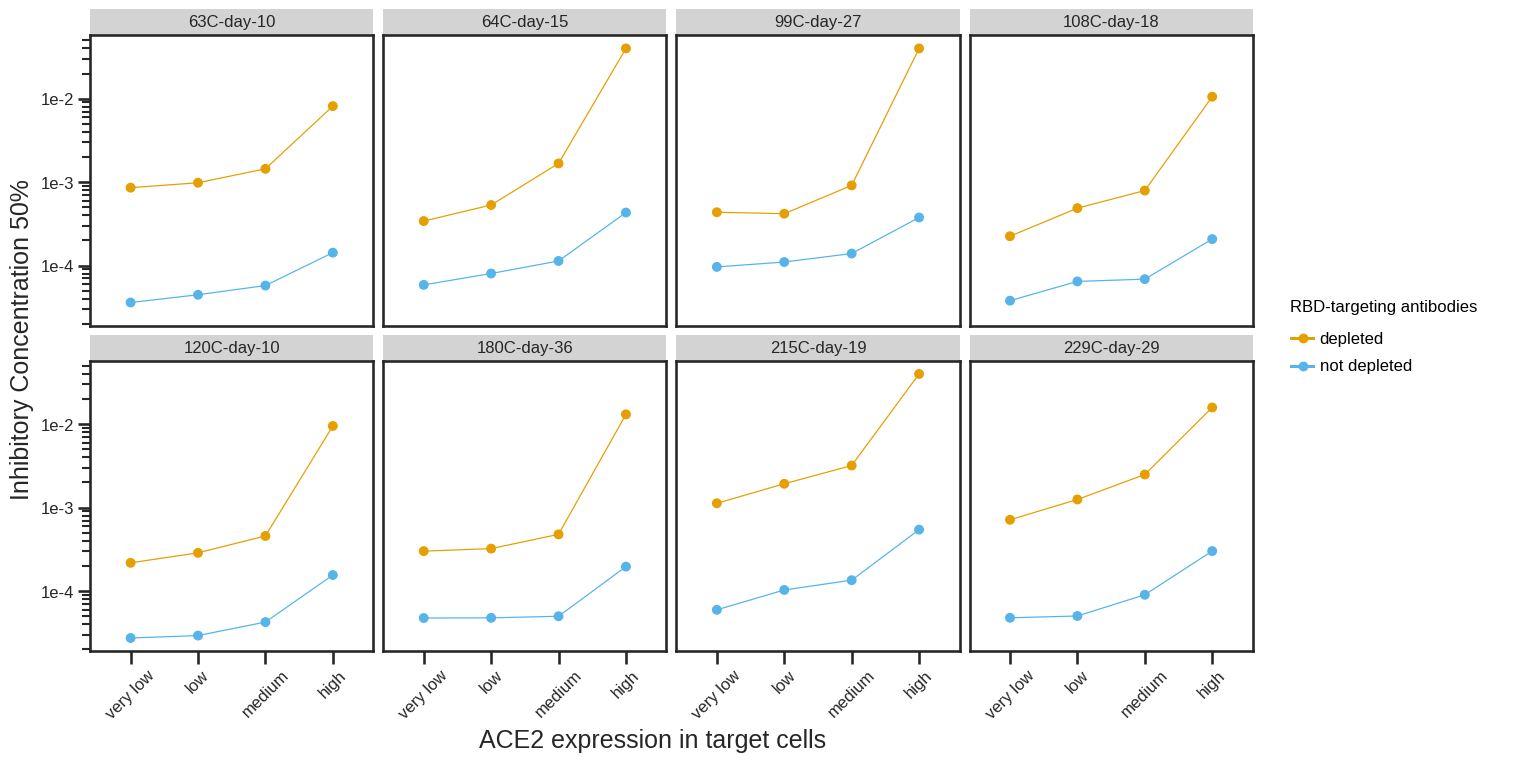

In [14]:
IC50 = (ggplot(fitparams, aes(x='cells', y='ic50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
        geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=18),
                   strip_text = element_text(size=12)
                  ) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='Inhibitory Concentration 50%') +
              xlab('ACE2 expression in target cells') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50.draw()
IC50.save(f'./{resultsdir}/IC50.pdf')

## Plot NT50 values

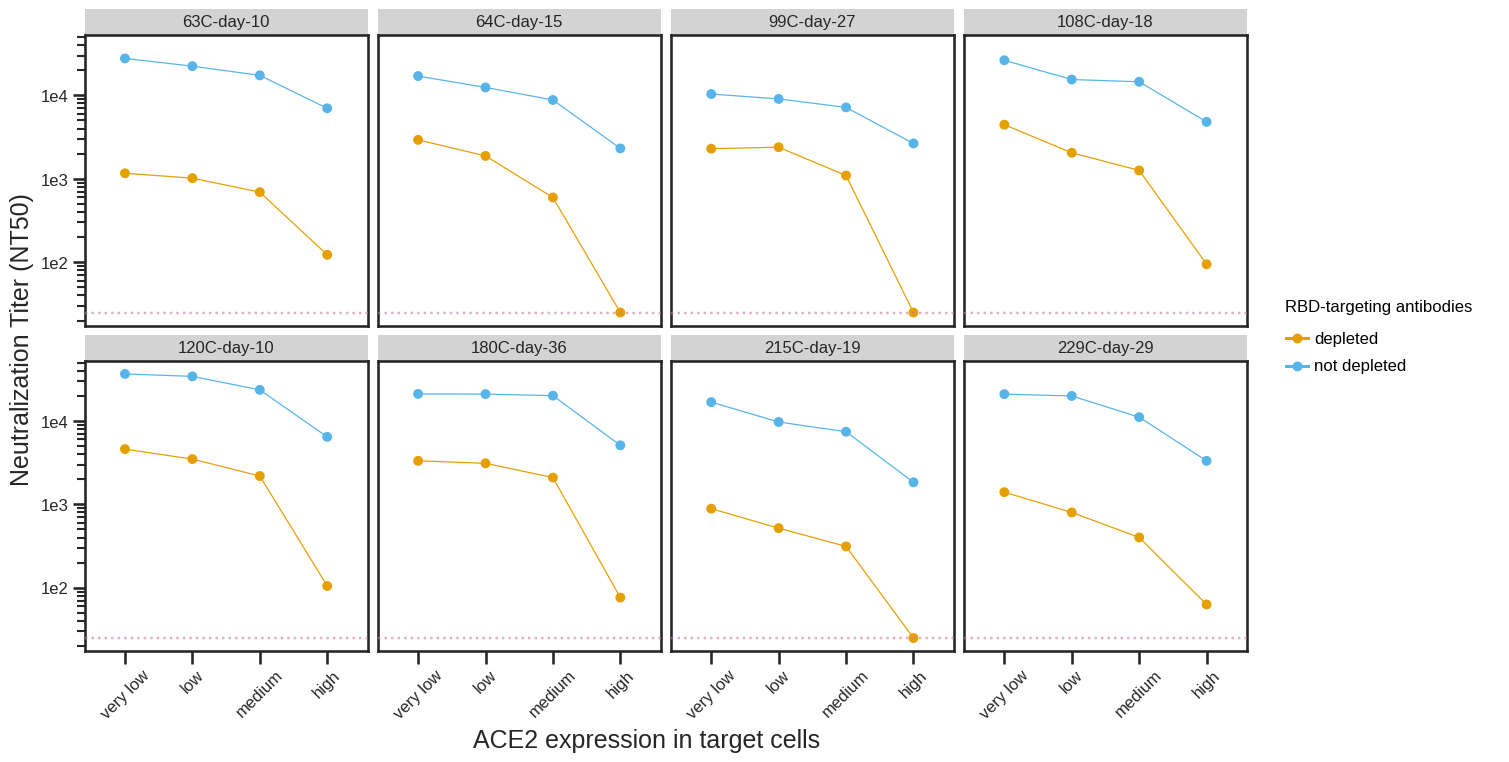

In [15]:
NT50 = (ggplot(fitparams, aes(x='cells', y='NT50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
             geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=18),
                   strip_text = element_text(size=12)
                  ) +
                geom_hline(yintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='Neutralization Titer (NT50)') +
              xlab('ACE2 expression in target cells') +
              
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = NT50.draw()
NT50.save(f'./{resultsdir}/NT50.pdf')

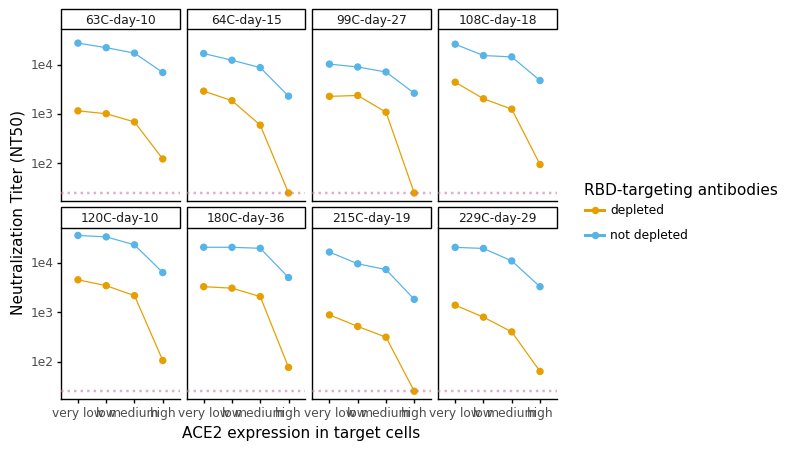

In [16]:
#why wont the x axis labels change or angle in theme_classic()?
NT50 = (ggplot(fitparams, aes(x='cells', y='NT50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=2) +
             geom_line(alpha=1) +
             theme(figure_size=(4,1),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=18),
                   strip_text = element_text(size=12)
                  ) +
                geom_hline(yintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='Neutralization Titer (NT50)') +
              xlab('ACE2 expression in target cells') +
              theme_classic() +
              
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = NT50.draw()
NT50.save(f'./{resultsdir}/NT50.pdf')

In [17]:
#copy_merged = fitparams.merge(ACE2_expression_df[['column_you_want', 'other_column_you_want']], on='cells')

In [18]:
df_merged = pd.merge(fitparams, ACE2_expression_df, on='cells')
df_merged

,serum,RBD-targeting antibodies,ic50,ic50_bound,NT50,ic50_is_bound,sample,cells,MFI (mode),RLU/ul,relative MFI,relative RLU/ul
0,63C-day-10__very low,not depleted,0.000036,interpolated,27722.423638,False,63C-day-10,very low,1119,1830.92,0.018373,0.035987
1,63C-day-10__very low,depleted,0.000857,interpolated,1166.622681,False,63C-day-10,very low,1119,1830.92,0.018373,0.035987
2,64C-day-15__very low,not depleted,0.000059,interpolated,17037.797799,False,64C-day-15,very low,1119,1830.92,0.018373,0.035987
3,64C-day-15__very low,depleted,0.000341,interpolated,2929.899361,False,64C-day-15,very low,1119,1830.92,0.018373,0.035987
4,99C-day-27__very low,not depleted,0.000096,interpolated,10374.149491,False,99C-day-27,very low,1119,1830.92,0.018373,0.035987
...,...,...,...,...,...,...,...,...,...,...,...,...
59,180C-day-36__high,depleted,0.013110,interpolated,76.275648,False,180C-day-36,high,60904,50877.35,1.000000,1.000000
60,215C-day-19__high,not depleted,0.000544,interpolated,1836.921925,False,215C-day-19,high,60904,50877.35,1.000000,1.000000
61,215C-day-19__high,depleted,0.040000,lower,25.000000,True,215C-day-19,high,60904,50877.35,1.000000,1.000000
62,229C-day-29__high,not depleted,0.000301,interpolated,3317.114196,False,229C-day-29,high,60904,50877.35,1.000000,1.000000


In [19]:
from plotnine import ggplot, aes, geom_point, geom_line, facet_grid

In [20]:
from plotnine import labs

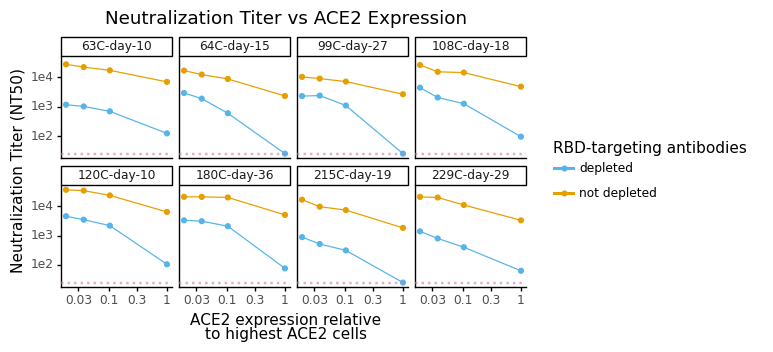

In [21]:
plot = (
    ggplot(df_merged) +
    aes(x="relative MFI", y="NT50", group='RBD-targeting antibodies', color='RBD-targeting antibodies')+
    geom_point() +
    geom_line() +
    theme_classic() +
    scale_color_manual(values= ['#56B4E9','#E69F00']) +
    labs(title="Neutralization Titer vs ACE2 Expression", x="ACE2 expression relative\nto highest ACE2 cells", y="Neutralization Titer (NT50)") +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap('sample', ncol=4) +
    theme(figure_size=(6,3)) +
    geom_hline(yintercept=25,
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7])
   

)

plot.draw()
plot.save(f'{resultsdir}/NT50_vs_ACE2_expression.pdf')

## Plot neut curves for all samples

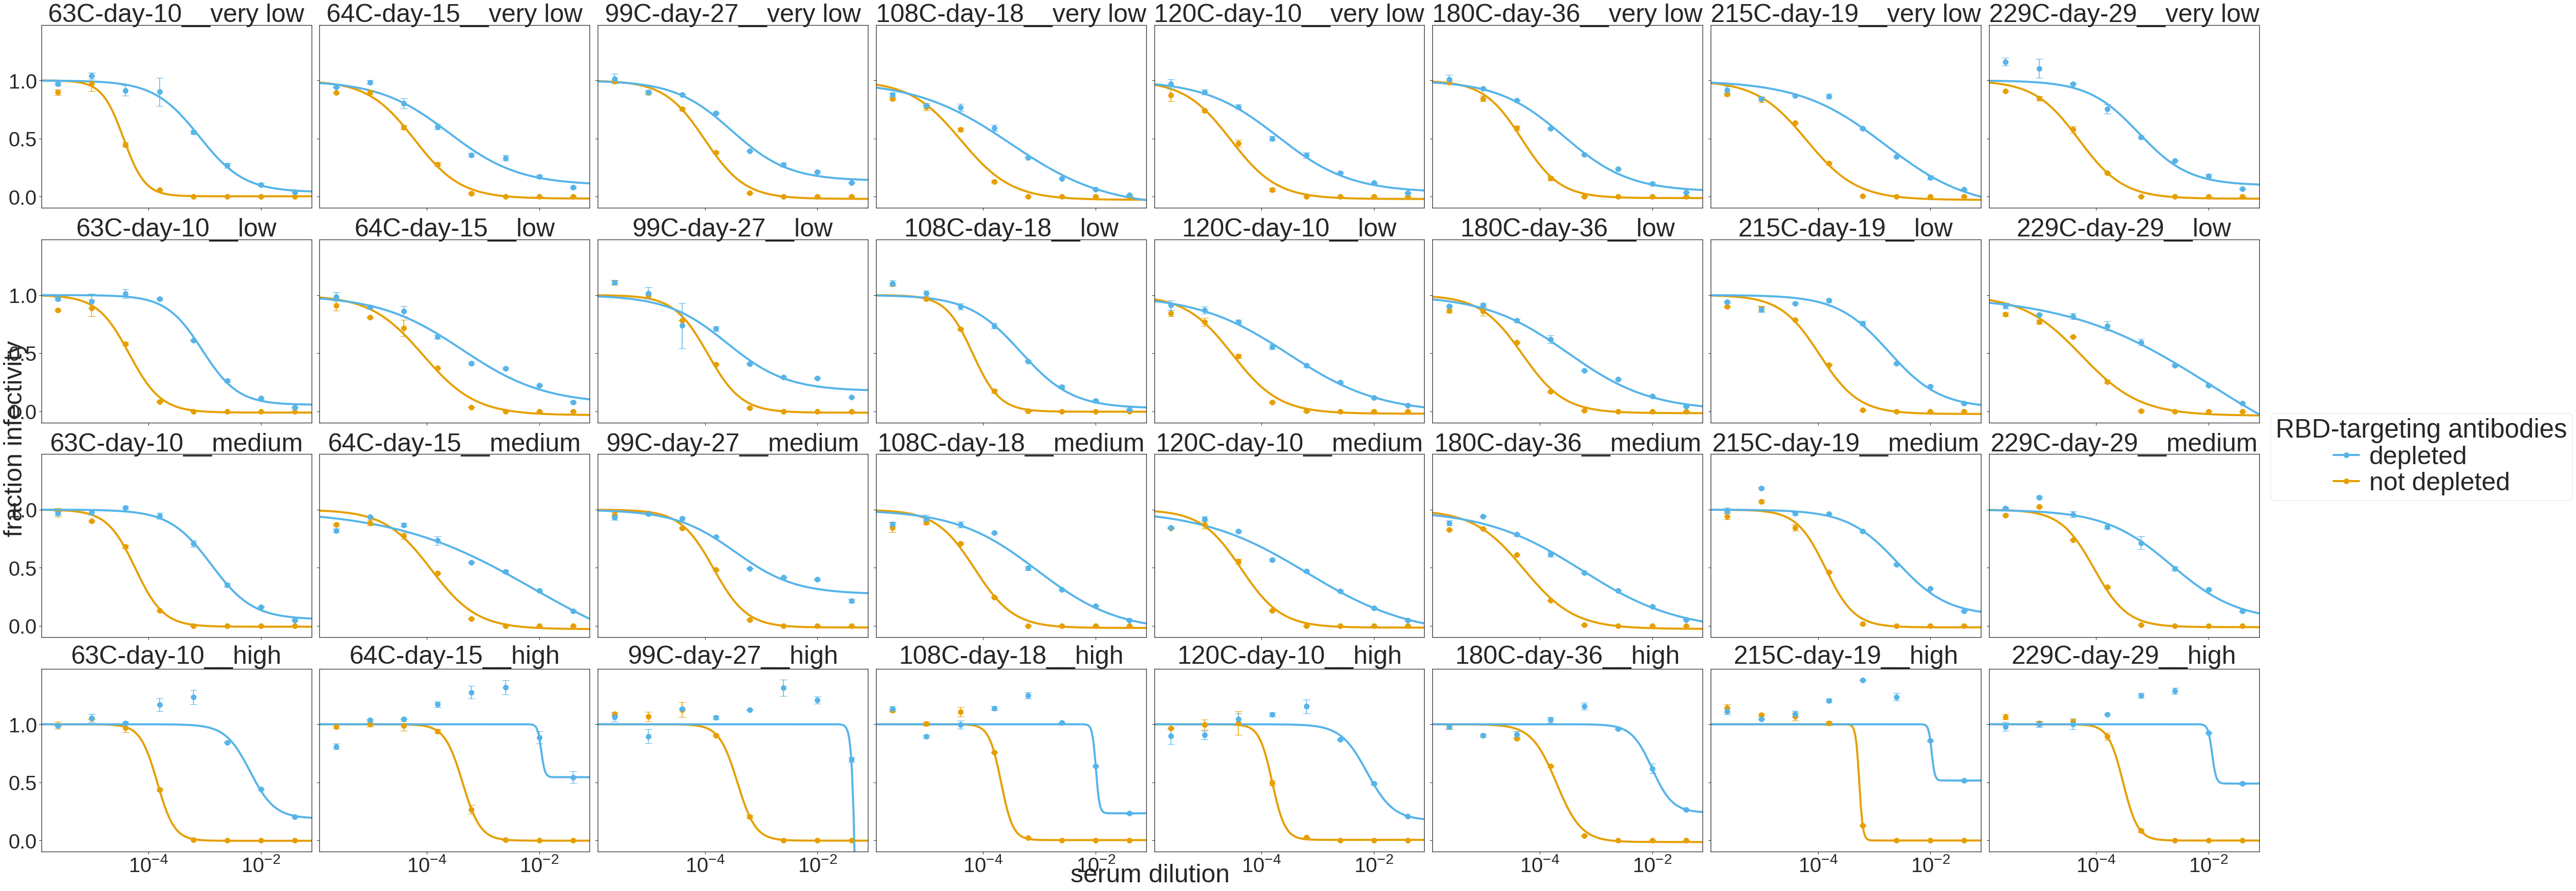

In [22]:
fig, axes = fits.plotSera(
                          xlabel='serum dilution',
                          ncol=8,
                          widthscale=2.5,
                          heightscale=2.5,
                          titlesize=50, labelsize=50, ticksize=40, legendfontsize=50, yticklocs=[0,0.5,1],
                          markersize=10, linewidth=4,
                          virus_to_color_marker={
                          'depleted': ('#56B4E9', 'o'),
                          'not depleted': ('#E69F00', 'o')},
                          legendtitle='RBD-targeting antibodies',
                    
                         )